# Latent Semantic Analysis
1) 단어 ‘database’와 가장 유사한 단어 탐색  
2) 문서 ‘D6’과 가장 유사한 문서 탐색  
  

## 목차

## 1. TF-IDF Matrix     
## 2. Latent Semantic Analysis(LSA)  
    2-1 SVD
    2-2 Latent semantic of terms  
    2-3 Latent semantic of Docs    
### 3. 추가 분석
    3-1 Term network by cosine similarity
    3-2 Document network by cosine similarity
    3-3 correlation & heatmap 
---- 

In [1]:
# 사용한 모듈
import pandas as pd
from math import log

import numpy as np
from numpy import array
from numpy import dot
from numpy.linalg import norm
from scipy.linalg import svd

import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

In [2]:
# csv파일을 읽어와 dataframe 저장
df = pd.read_csv('./data/data_week9.csv',index_col=0)
df

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10
database,11,21,12,0,37,2,0,3,1,6
SQL,21,10,0,7,31,0,0,21,5,0
index,9,0,5,2,20,0,1,0,11,0
regression,3,5,2,2,0,18,32,11,21,8
likelihood,0,3,0,0,3,7,12,4,27,4
linear,3,0,0,4,0,16,21,2,16,15


# 1. TF-IDF Matrix

## idf 
- idf(d,t)=log(n / (1+df(t)) ) 
- N = 10 ,N : 전체 docs의 수 
  
df(t : term) : 각 단어가 속한 문서의 수
- df(database) : 8 
- df(SQL) : 6
- df(index) : 6
- df(regression) : 9 
- df(likelihood) : 7 
- df(linear) : 7


In [3]:
terms = list(df.index)
terms

['database', 'SQL', 'index', 'regression', 'likelihood', 'linear']

In [4]:
N = 10
df_t = [8,6,6,9,7,7]
idf = []

In [5]:
# 각 단어에 대한 idf값 계산
for i, dft in zip(terms, df_t):
    idf.append(round(log( N / (1+dft ) ),4))
idf

[0.1054, 0.3567, 0.3567, 0.0, 0.2231, 0.2231]

regression의 idf값이 0이 나와 idf의 역할을 못할 것이라 생각하여   
 idf(d,t)=log(n/(df(t)+1))+1로 전체 값에 1을 더해주었습니다.  
 아래와 같이 다시 계산했습니다. 

In [6]:
# idf 값 계산 수정
N = 10
df_t = [8,6,6,9,7,7]
idf = []
for i, dft in zip(terms, df_t):
    idf.append(round(log( N / (1+dft ) ),4)+1)
idf

[1.1054, 1.3567, 1.3567, 1.0, 1.2231, 1.2231]

In [7]:
idf= np.array(idf)
idf

array([1.1054, 1.3567, 1.3567, 1.    , 1.2231, 1.2231])

In [8]:
df_idf = pd.DataFrame(data=idf.transpose(), index=terms, columns=['idf'])

In [9]:
df_idf

,idf
database,1.1054
SQL,1.3567
index,1.3567
regression,1.0000
likelihood,1.2231
linear,1.2231


In [10]:
# TF-IDF matrix 생성
tf_idf = pd.DataFrame(index = terms, columns=df.columns)
tf_idf

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10
database,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SQL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
index,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
regression,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
likelihood,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
linear,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# TF-IDF 계산 (df * idf = TF * IDF)
# df끼리의 곱보다 이 방법을 먼저 생각해서 계산 후 df에 채워넣었습니다.
for i in range(6):
    tf_idf.iloc[i] = round(df.iloc[i]*idf[i],4)

In [12]:
tf_idf

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10
database,12.1594,23.2134,13.2648,0,40.8998,2.2108,0,3.3162,1.1054,6.6324
SQL,28.4907,13.567,0,9.4969,42.0577,0,0,28.4907,6.7835,0
index,12.2103,0,6.7835,2.7134,27.134,0,1.3567,0,14.9237,0
regression,3,5,2,2,0,18,32,11,21,8
likelihood,0,3.6693,0,0,3.6693,8.5617,14.6772,4.8924,33.0237,4.8924
linear,3.6693,0,0,4.8924,0,19.5696,25.6851,2.4462,19.5696,18.3465


----
# 2. Latent Semantic Analysis(LSA)
## 2-1 SVD

In [13]:
# SVD 계산하기 위해 df를 numpy로, data type을 float으로 설정했습니다.
TF_IDF = tf_idf.to_numpy( dtype='float')
TF_IDF

array([[12.1594, 23.2134, 13.2648,  0.    , 40.8998,  2.2108,  0.    ,
         3.3162,  1.1054,  6.6324],
       [28.4907, 13.567 ,  0.    ,  9.4969, 42.0577,  0.    ,  0.    ,
        28.4907,  6.7835,  0.    ],
       [12.2103,  0.    ,  6.7835,  2.7134, 27.134 ,  0.    ,  1.3567,
         0.    , 14.9237,  0.    ],
       [ 3.    ,  5.    ,  2.    ,  2.    ,  0.    , 18.    , 32.    ,
        11.    , 21.    ,  8.    ],
       [ 0.    ,  3.6693,  0.    ,  0.    ,  3.6693,  8.5617, 14.6772,
         4.8924, 33.0237,  4.8924],
       [ 3.6693,  0.    ,  0.    ,  4.8924,  0.    , 19.5696, 25.6851,
         2.4462, 19.5696, 18.3465]])

In [14]:
# Singular-Value Decomposition

# SVD
U, sigma, VT = svd(TF_IDF)

print('U : ' ,U,'\n')
print('시그마 : ',sigma,'\n')
print('V^T : ',VT,'\n')

U :  [[-0.50261347  0.31719786  0.68331567  0.32376161 -0.25811214  0.09165948]
 [-0.6406293   0.3359526  -0.67120349  0.05503951  0.0064802   0.15213309]
 [-0.34776815  0.09320375  0.2327084  -0.57139835  0.5279539  -0.45933189]
 [-0.29466492 -0.55549094 -0.12111489  0.30811555 -0.273244   -0.64833333]
 [-0.25948682 -0.4168212   0.06693532 -0.62285733 -0.48003295  0.36886781]
 [-0.24873739 -0.54362149  0.09624559  0.28769177  0.59119108  0.44840687]] 

시그마 :  [84.81945737 64.73856359 25.10017968 22.0356422  13.29707574  8.38466157] 

V^T :  [[-0.35848491 -0.2686205  -0.11336411 -0.10414921 -0.68249271 -0.15921448
  -0.236956   -0.29519209 -0.35034597 -0.13586301]
 [ 0.16845173  0.1176148   0.05759831 -0.00505399  0.43408858 -0.36307153
  -0.58280566  0.01767035 -0.49504085 -0.22170637]
 [-0.31804953  0.25481465  0.41435533 -0.21969083  0.25012229  0.07120164
  -0.00420158 -0.70224196  0.04882935  0.22535089]
 [ 0.02304856  0.34114985  0.04695953  0.04519981 -0.10134277  0.29766082
   

In [15]:
Sigma = np.diag(sigma)
Sigma

array([[84.81945737,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        , 64.73856359,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        , 25.10017968,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        , 22.0356422 ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , 13.29707574,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         8.38466157]])

In [16]:
U_df = pd.DataFrame(U)
U_df

,0,1,2,3,4,5
0,-0.502613,0.317198,0.683316,0.323762,-0.258112,0.091659
1,-0.640629,0.335953,-0.671203,0.055040,0.006480,0.152133
2,-0.347768,0.093204,0.232708,-0.571398,0.527954,-0.459332
3,-0.294665,-0.555491,-0.121115,0.308116,-0.273244,-0.648333
4,-0.259487,-0.416821,0.066935,-0.622857,-0.480033,0.368868
5,-0.248737,-0.543621,0.096246,0.287692,0.591191,0.448407


In [17]:
Sigma_df = pd.DataFrame(Sigma)
Sigma_df

,0,1,2,3,4,5
0,84.819457,0.000000,0.00000,0.000000,0.000000,0.000000
1,0.000000,64.738564,0.00000,0.000000,0.000000,0.000000
2,0.000000,0.000000,25.10018,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.00000,22.035642,0.000000,0.000000
4,0.000000,0.000000,0.00000,0.000000,13.297076,0.000000
5,0.000000,0.000000,0.00000,0.000000,0.000000,8.384662


## 2-2 Latent semantic of terms

In [18]:
# pick two left singular vectors
U_df.iloc[:, :2]

,0,1
0,-0.502613,0.317198
1,-0.640629,0.335953
2,-0.347768,0.093204
3,-0.294665,-0.555491
4,-0.259487,-0.416821
5,-0.248737,-0.543621


In [19]:
# The first two singular values
Sigma_df.iloc[:2,:2]

,0,1
0,84.819457,0.000000
1,0.000000,64.738564


In [20]:
LSM= U_df.iloc[:, :2].dot(Sigma_df.iloc[:2,:2])
LSM

,0,1
0,-42.631402,20.534934
1,-54.337830,21.749089
2,-29.497506,6.033877
3,-24.993319,-35.961686
4,-22.009531,-26.984406
5,-21.097771,-35.193275


In [21]:
LSM = LSM .rename(index = {0: terms[0], 1: terms[1], 2:terms[2], 3: terms[3],4: terms[4], 5:terms[5] })
LSM = LSM.rename(columns= {0: 'Dim1', 1: 'Dim2'})

In [22]:
LSM

,Dim1,Dim2
database,-42.631402,20.534934
SQL,-54.337830,21.749089
index,-29.497506,6.033877
regression,-24.993319,-35.961686
likelihood,-22.009531,-26.984406
linear,-21.097771,-35.193275


In [23]:
#코사인유사도를 사용해 모든 similarity 계산  
for n in range(5):
    for n2 in range(n+1,6):
        a,b = LSM.iloc[n], LSM.iloc[n2]
        print('{}-{} 코사인 유사도 : '.format(LSM.index[n],LSM.index[n2]),round(dot(a, b)/(norm(a)*norm(b)),4),'\n')

database-SQL 코사인 유사도 :  0.9977 

database-index 코사인 유사도 :  0.9696 

database-regression 코사인 유사도 :  0.1578 

database-likelihood 코사인 유사도 :  0.2331 

database-linear 코사인 유사도 :  0.091 

SQL-index 코사인 유사도 :  0.984 

SQL-regression 코사인 유사도 :  0.2247 

SQL-likelihood 코사인 유사도 :  0.2988 

SQL-linear 코사인 유사도 :  0.1586 

index-regression 코사인 유사도 :  0.3946 

index-likelihood 코사인 유사도 :  0.4639 

index-linear 코사인 유사도 :  0.3319 

regression-likelihood 코사인 유사도 :  0.997 

regression-linear 코사인 유사도 :  0.9977 

likelihood-linear 코사인 유사도 :  0.9896 



# 결과 해석
1. database단어와 가장 유사한(코사인 유사도가 가장 높은) 단어는 SQL입니다.  
코사인 유사도가 0.9977의 값이 나왔기 때문입니다.  

2. 두번째로 유사한 단어는 index로, 코사인유사도는 0.9696입니다.

## 2-3 Latent semantic of documents

In [24]:
np.diag(sigma)

array([[84.81945737,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        , 64.73856359,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        , 25.10017968,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        , 22.0356422 ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , 13.29707574,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         8.38466157]])

In [25]:
Sig = np.zeros((6, 10)) # 대각 행렬의 크기인 6 x 10의 임의의 행렬 생성
Sig[:6, :6] = np.diag(sigma) # 시그마를 대각행렬에 삽입
Sig = Sig.round(4) 

In [26]:
# Latent semantic of docs
Sigma_VT = Sig.dot(VT)

In [27]:
Sigma_VT

array([[-30.40651103, -22.78425626,  -9.61548705,  -8.8338836 ,
        -57.88869033, -13.50449277, -20.09848934, -25.03804546,
        -29.71616965, -11.52383259],
       [ 10.90532917,   7.61421734,   3.72883406,  -0.32718855,
         28.10228716, -23.50474237, -37.73002236,   1.14395366,
        -32.04825146, -14.35296025],
       [ -7.98310672,   6.39589862,  10.40040172,  -5.51428383,
          6.27811945,   1.78717548,  -0.10546052, -17.62641376,
          1.22562634,   5.65635236],
       [  0.50788886,   7.51744166,   1.03478135,   0.99600485,
         -2.23314884,   6.55913476,   7.33205774,   3.68752087,
        -16.26471398,   6.84309759],
       [  4.84214634,  -9.0313649 ,  -0.38891935,   3.83995415,
          2.2799276 ,   1.97045222,   0.11172979,  -4.57936007,
         -2.38355253,   4.59992745],
       [ -0.45934047,   2.30354831,  -3.19671453,   1.09556572,
         -0.96280711,   0.46592161,  -4.43854051,   0.40821638,
          1.6199143 ,   5.45262619]])

In [28]:
LSD = pd.DataFrame(data = Sigma_VT,index= ['Dim'+str(i) for i in range(1,7)], columns=df.columns)
LSD

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10
Dim1,-30.406511,-22.784256,-9.615487,-8.833884,-57.888690,-13.504493,-20.098489,-25.038045,-29.716170,-11.523833
Dim2,10.905329,7.614217,3.728834,-0.327189,28.102287,-23.504742,-37.730022,1.143954,-32.048251,-14.352960
Dim3,-7.983107,6.395899,10.400402,-5.514284,6.278119,1.787175,-0.105461,-17.626414,1.225626,5.656352
Dim4,0.507889,7.517442,1.034781,0.996005,-2.233149,6.559135,7.332058,3.687521,-16.264714,6.843098
Dim5,4.842146,-9.031365,-0.388919,3.839954,2.279928,1.970452,0.111730,-4.579360,-2.383553,4.599927
Dim6,-0.459340,2.303548,-3.196715,1.095566,-0.962807,0.465922,-4.438541,0.408216,1.619914,5.452626


In [29]:
LSD.iloc[:2,:]

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10
Dim1,-30.406511,-22.784256,-9.615487,-8.833884,-57.888690,-13.504493,-20.098489,-25.038045,-29.716170,-11.523833
Dim2,10.905329,7.614217,3.728834,-0.327189,28.102287,-23.504742,-37.730022,1.143954,-32.048251,-14.352960


In [30]:
# 전체 문서에 대한 코사인 유사도 계산
for i in range(0,9):
    for j in range(i,10):
        a, b = LSD[LSD.columns[i]][:2], LSD[LSD.columns[j]][:2]
        print('{}-{} 코사인 유사도 : '.format(LSD.columns[i],LSD.columns[j]),round(dot(a, b)/(norm(a)*norm(b)),4),'\n')

D1-D1 코사인 유사도 :  1.0 

D1-D2 코사인 유사도 :  0.9998 

D1-D3 코사인 유사도 :  0.9997 

D1-D4 코사인 유사도 :  0.9282 

D1-D5 코사인 유사도 :  0.9942 

D1-D6 코사인 유사도 :  0.1762 

D1-D7 코사인 유사도 :  0.1446 

D1-D8 코사인 유사도 :  0.9557 

D1-D9 코사인 유사도 :  0.3925 

D1-D10 코사인 유사도 :  0.3261 

D2-D2 코사인 유사도 :  1.0 

D2-D3 코사인 유사도 :  0.9989 

D2-D4 코사인 유사도 :  0.9361 

D2-D5 코사인 유사도 :  0.9916 

D2-D6 코사인 유사도 :  0.1977 

D2-D7 코사인 유사도 :  0.1662 

D2-D8 코사인 유사도 :  0.9619 

D2-D9 코사인 유사도 :  0.4124 

D2-D10 코사인 유사도 :  0.3466 

D3-D3 코사인 유사도 :  1.0 

D3-D4 코사인 유사도 :  0.9183 

D3-D5 코사인 유사도 :  0.9966 

D3-D6 코사인 유사도 :  0.151 

D3-D7 코사인 유사도 :  0.1192 

D3-D8 코사인 유사도 :  0.9479 

D3-D9 코사인 유사도 :  0.3688 

D3-D10 코사인 유사도 :  0.3018 

D4-D4 코사인 유사도 :  1.0 

D4-D5 코사인 유사도 :  0.8828 

D4-D6 코사인 유사도 :  0.5299 

D4-D7 코사인 유사도 :  0.5025 

D4-D8 코사인 유사도 :  0.9966 

D4-D9 코사인 유사도 :  0.7066 

D4-D10 코사인 유사도 :  0.6545 

D5-D5 코사인 유사도 :  1.0 

D5-D6 코사인 유사도 :  0.0695 

D5-D7 코사인 유사도 :  0.0375 

D5-D8 코사인 유사도 :  0.9186 

D5-D9 코사인 유사도 :  0.2914 

In [31]:
for j in range(0,10):
    a, b = LSD[LSD.columns[5]][:2], LSD[LSD.columns[j]][:2]
    print('{}-{} 코사인 유사도 : '.format(LSD.columns[5],LSD.columns[j]),round(dot(a, b)/(norm(a)*norm(b)),4),'\n')

D6-D1 코사인 유사도 :  0.1762 

D6-D2 코사인 유사도 :  0.1977 

D6-D3 코사인 유사도 :  0.151 

D6-D4 코사인 유사도 :  0.5299 

D6-D5 코사인 유사도 :  0.0695 

D6-D6 코사인 유사도 :  1.0 

D6-D7 코사인 유사도 :  0.9995 

D6-D8 코사인 유사도 :  0.4581 

D6-D9 코사인 유사도 :  0.9745 

D6-D10 코사인 유사도 :  0.988 



# 결과 해석
* D6 -D6은 같은 문서이기때문에 유사도가 1이 나왔습니다. 따라서 제외 해야합니다.    
  
* D6와 가장 유사한((코사인 유사도가 가장 높은)) 문서는 D7입니다.  
    코사인 유사도가  0.9995 값이 나왔기 때문입니다.  

* 두번째로 유사한 문서는 D9로, 코사인유사도는 0.9745입니다.

--------
# 3. 추가 
## 3-1 term network by cosine similarity


In [32]:
# 전체 단어에 대한 코사인 유사도 계산
term_net = pd.DataFrame(columns=df.transpose().columns, index=df.transpose().columns)
#코사인유사도를 사용해 모든 similarity 계산  
for n in range(5):
    for n2 in range(n+1,6):
        a,b = LSM.iloc[n], LSM.iloc[n2]
        #print('{}-{} 코사인 유사도 : '.format(LSM.index[n],LSM.index[n2]),round(dot(a, b)/(norm(a)*norm(b)),4),'\n')
        term_net.iloc[n,n2] = round(dot(a, b)/(norm(a)*norm(b)),4)

In [33]:
term_net = term_net.fillna(term_net.T)
term_net = term_net.fillna(1)
term_net

,database,SQL,index,regression,likelihood,linear
database,1.0000,0.9977,0.9696,0.1578,0.2331,0.0910
SQL,0.9977,1.0000,0.9840,0.2247,0.2988,0.1586
index,0.9696,0.9840,1.0000,0.3946,0.4639,0.3319
regression,0.1578,0.2247,0.3946,1.0000,0.9970,0.9977
likelihood,0.2331,0.2988,0.4639,0.9970,1.0000,0.9896
linear,0.0910,0.1586,0.3319,0.9977,0.9896,1.0000


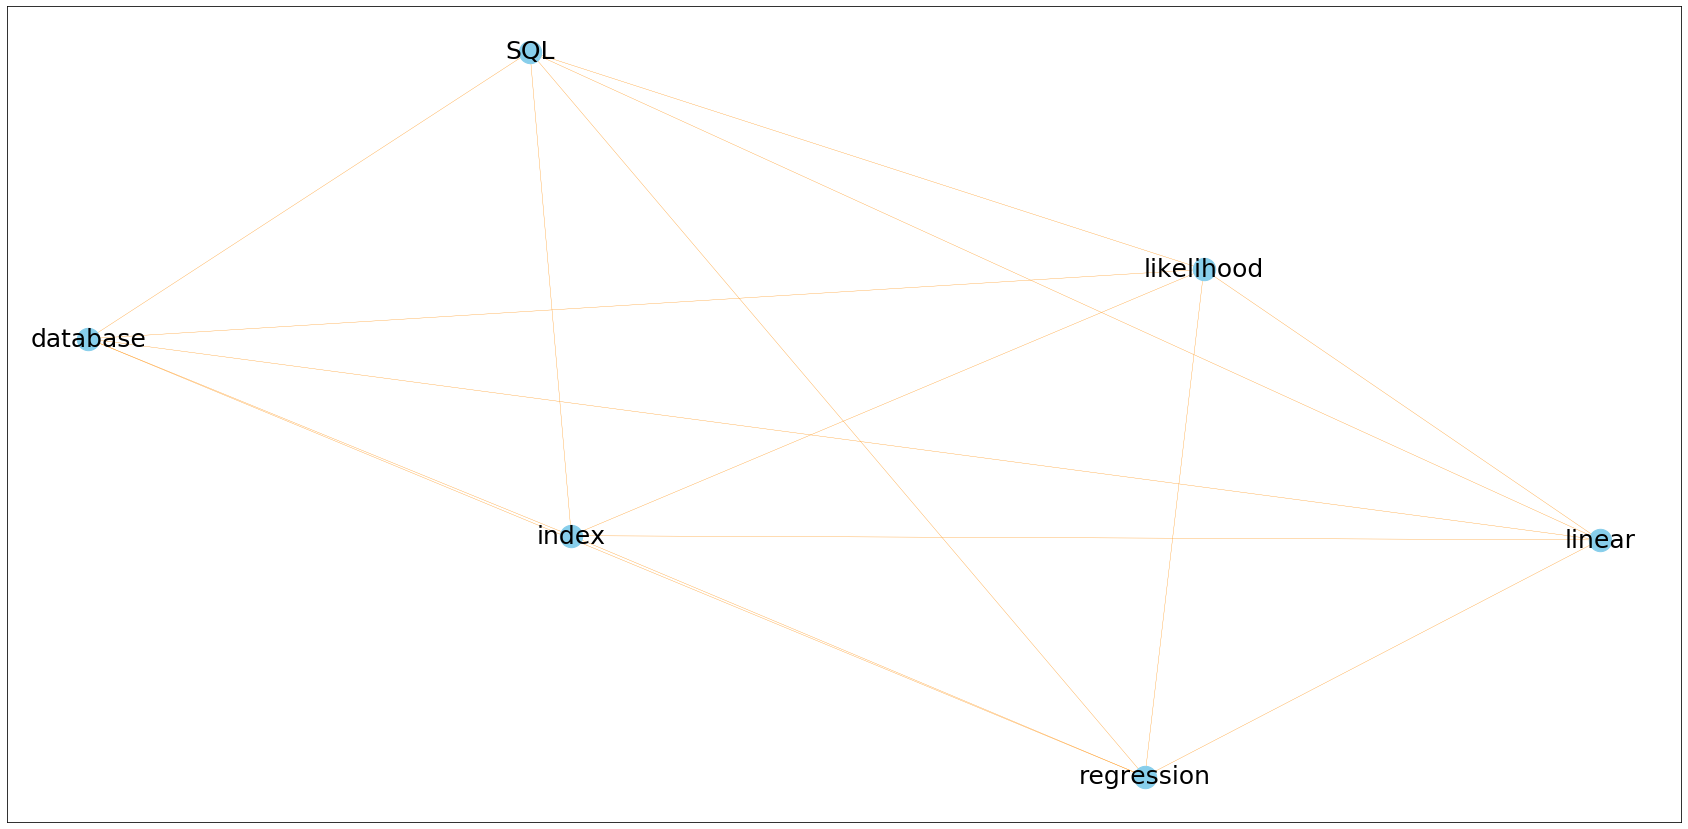

In [34]:
plt.figure(figsize=(30,15))
G = nx.from_pandas_adjacency(term_net)
nx.draw_networkx(G,node_size=500, node_color='skyblue',font_size=25,edge_color='darkorange',width= 0.3)

#plt.savefig("Car Maker Patent W\ord40 Network img.png")

--- 
## 3-2 Document network by cosine similarity

In [35]:
# 전체 문서에 대한 코사인 유사도 계산
doc_net = pd.DataFrame(columns=df.columns, index=df.columns)
for i in range(0,9):
    for j in range(i,10):
        a, b = LSD[LSD.columns[i]][:2], LSD[LSD.columns[j]][:2]
        #print('{}-{} 코사인 유사도 : '.format(LSD.columns[i],LSD.columns[j]),round(dot(a, b)/(norm(a)*norm(b)),4),'\n')
        doc_net.iloc[i,j] = round(dot(a, b)/(norm(a)*norm(b)),4)

In [36]:
docs = doc_net.fillna(doc_net.T)
docs = docs.fillna(1)
docs

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10
D1,1.0000,0.9998,0.9997,0.9282,0.9942,0.1762,0.1446,0.9557,0.3925,0.3261
D2,0.9998,1.0000,0.9989,0.9361,0.9916,0.1977,0.1662,0.9619,0.4124,0.3466
D3,0.9997,0.9989,1.0000,0.9183,0.9966,0.1510,0.1192,0.9479,0.3688,0.3018
D4,0.9282,0.9361,0.9183,1.0000,0.8828,0.5299,0.5025,0.9966,0.7066,0.6545
D5,0.9942,0.9916,0.9966,0.8828,1.0000,0.0695,0.0375,0.9186,0.2914,0.2227
D6,0.1762,0.1977,0.1510,0.5299,0.0695,1.0000,0.9995,0.4581,0.9745,0.9880
D7,0.1446,0.1662,0.1192,0.5025,0.0375,0.9995,1.0000,0.4294,0.9669,0.9826
D8,0.9557,0.9619,0.9479,0.9966,0.9186,0.4581,0.4294,1.0000,0.6457,0.5898
D9,0.3925,0.4124,0.3688,0.7066,0.2914,0.9745,0.9669,0.6457,1.0000,0.9975
D10,0.3261,0.3466,0.3018,0.6545,0.2227,0.9880,0.9826,0.5898,0.9975,1.0000


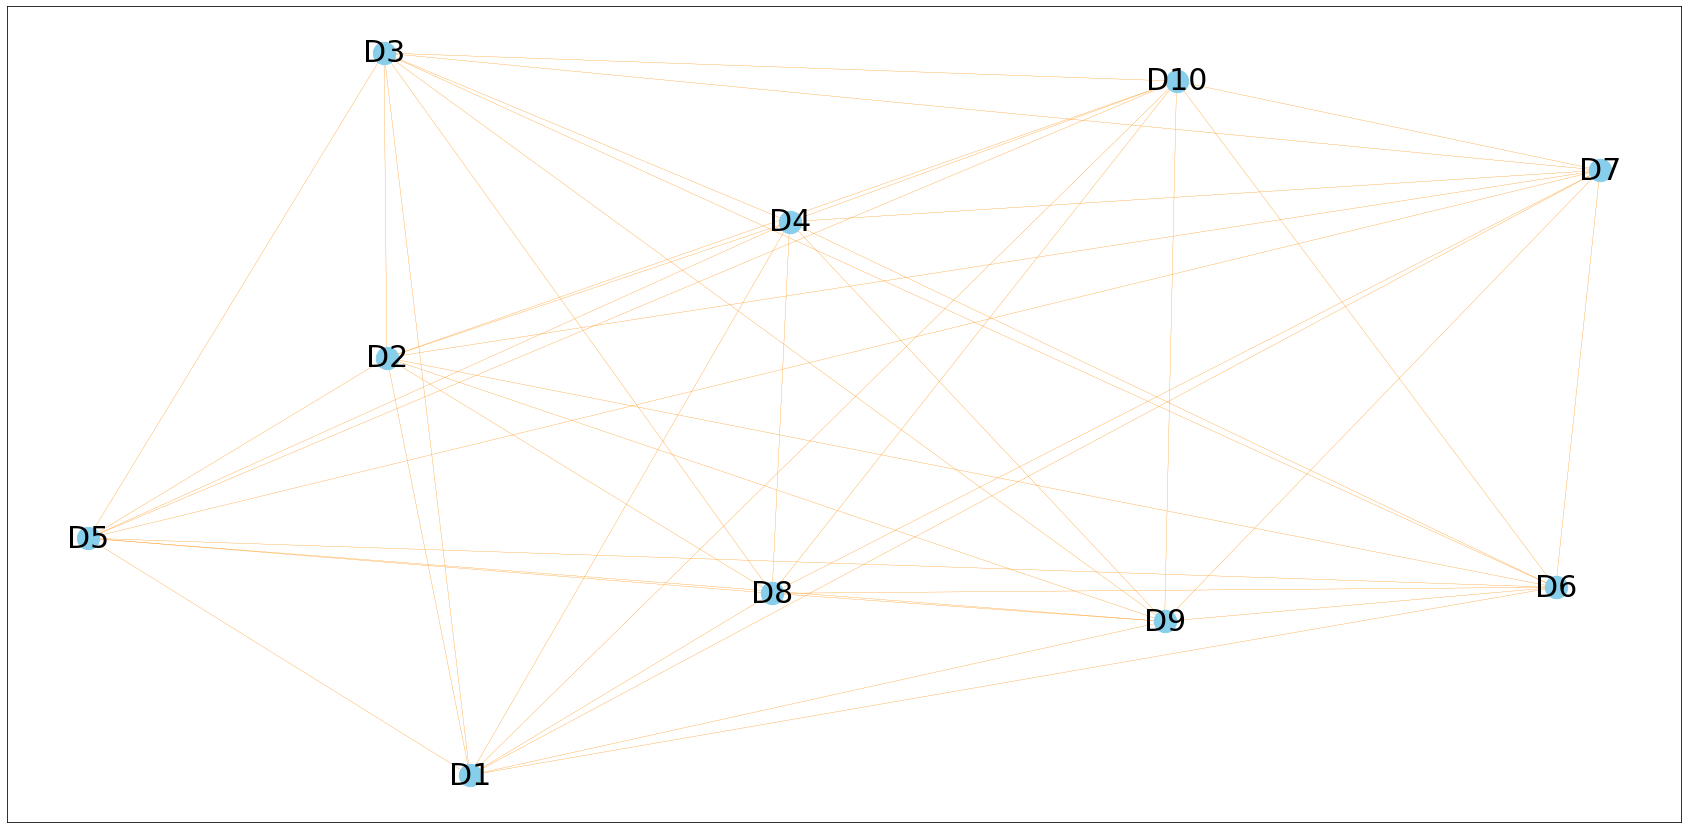

In [37]:
import networkx as nx 
import matplotlib.pyplot as plt
plt.figure(figsize=(30,15))
G = nx.from_pandas_adjacency(docs)
nx.draw_networkx(G,node_size=500, node_color='skyblue',font_size=30,edge_color='darkorange',width= 0.3)

#plt.savefig("Car Maker Patent W\ord40 Network img.png")


---- 
## 3-3 Correlation & heatmap

In [38]:
# term correlation
term_corr = df.transpose().corr()
term_corr

,database,SQL,index,regression,likelihood,linear
database,1.000000,0.651862,0.651695,-0.584977,-0.349591,-0.612840
SQL,0.651862,1.000000,0.630777,-0.485260,-0.276070,-0.626743
index,0.651695,0.630777,1.000000,-0.296514,0.163385,-0.277078
regression,-0.584977,-0.485260,-0.296514,1.000000,0.719554,0.865087
likelihood,-0.349591,-0.276070,0.163385,0.719554,1.000000,0.655739
linear,-0.612840,-0.626743,-0.277078,0.865087,0.655739,1.000000


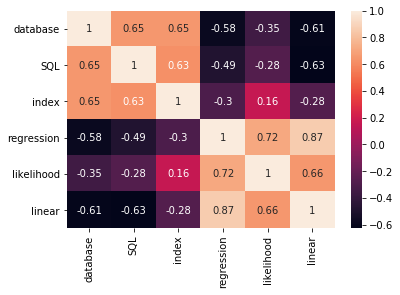

In [39]:
# corr 히트맵 
sns.heatmap(term_corr, annot=True)
plt.show()

- 각 term끼리의 상관관계를 분석했습니다.
[분석 결과]

1) database , SQL, index
- database , SQL, index terms에 대해서 해당 3개의 각각의 term과 높은 양의 상관관계를 가집니다.
- regression,linear과는 음의 상관관계를 가집니다.
- likelihood 와 index는 약한 양의 상관관계를 가집니다.  
    
2) regression, likelihood, linear
- regression, likelihood, linear끼리의 상관관계는 높은 양의 상관관계를 가지고
- database , SQL, index에 대해서는 낮음 음의 상관관계를 가집니다.

이 결과를 통해, 상관관계가 높은 [database, SQL, index] / [regression, likelihood, linear] 두 category로 분류할 수 있다고 생각합니다.

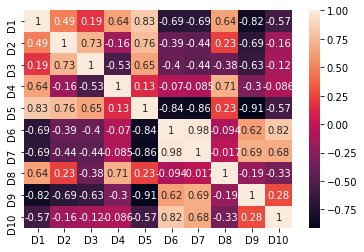

In [40]:
docs_corr = df.corr()
sns.heatmap(docs_corr, annot=True)
plt.show()

- 각 문서의 상관관계를 분석했습니다.  
[분석 결과]

1) D1 - D5는 높은 양의 상관관계를 가지므로 동시 출현 단어가 많고 그 수도 비례한다고 판단할 수 있습니다.    
  
2) D1 - D9은 높은 음의 상관관계를 가지므로 동시 출현 단어가 있지만, 그 수는 반비례 한다고 판단이 됩니다.  
     
3) D2 - D5도 0.76으로 높은 양의 상관관계를 가집니다.      
  
4) D5와 양의 상관관계가 높은 D1과 D2의 상관관계는 0.49로 높은 양의 상관 관계를 가지지 않는걸로 보아, D5는 D1의 단어와 D2의 단어가 동시에 많이 포함 되어 있다고 판단 됩니다.     
  
5) D5 - D9는 모든 값 중 가장 높은 음의 관계를 가집니다. 이를 통해 D5와 D9의 동시 출현 단어가 있지만, 수가 크게 반비례한다고 판단이 됩니다.
     
3) D6 - D7은 0.98로 가장 높은 양의 상관관계를 가집니다.  
   위에서 계산하였지만, D6는 D7과 가장 유사한 문서라고 판단이 됩니다.
   
이 결과를 통해, 높은 양의 상관관계의 문서는 (D1 - D5 , D2 - D3 ,D2 - D5, D4 - D10, D7 - D9, D7 - D10)   
높은 음의 상관관계의 문서는 (D1 - D9, D5 - D6, D5- D7, D5- D9)로 분류할 수 있다고 생각합니다.  